# Functions/Procedures Starts Here

In [ ]:
import pandas as pd
import re
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datetime import datetime, timedelta
import os
import pickle

In [ ]:
# Load Data Files
def load_data(folder_path, expiration_str):
    ce_files = [f for f in os.listdir(folder_path) if re.match(rf'NIFTY{expiration_str}\d+CE.pkl', f)]
    pe_files = [f for f in os.listdir(folder_path) if re.match(rf'NIFTY{expiration_str}\d+PE.pkl', f)]

    # print(f"Identified CE files: {ce_files}")
    # print(f"Identified PE files: {pe_files}")

    ce_data_list = []
    for f in ce_files:
        data = pd.read_pickle(os.path.join(folder_path, f))
        ce_data_list.append(data)
        # print(f"Loaded CE file: {f} with {len(data)} rows")

    pe_data_list = []
    for f in pe_files:
        data = pd.read_pickle(os.path.join(folder_path, f))
        pe_data_list.append(data)
        # print(f"Loaded PE file: {f} with {len(data)} rows")

    ce_data = pd.concat(ce_data_list, ignore_index=True) if ce_data_list else pd.DataFrame()
    pe_data = pd.concat(pe_data_list, ignore_index=True) if pe_data_list else pd.DataFrame()

    return ce_data, pe_data

In [ ]:
# Calculate Time to Expiration (T)
def calculate_time_to_expiration(expiration_date, current_time, current_date):

  today = current_date
  current_time = datetime.combine(today, datetime.strptime(current_time, '%H:%M:%S').time())

  # Define the target time (12:00 AM next day)
  target_time = current_time + timedelta(days=1)
  target_time = target_time.replace(hour=0, minute=0, second=0, microsecond=0)
  time_difference = target_time - current_time
  M_current_day  = time_difference.total_seconds() / 60
  M_settlement_day = 15.5*60

  days_to_expiration = expiration_date - current_date - timedelta(days=1)
  M_other_days = days_to_expiration.total_seconds() / 60
  M_total = M_current_day + M_settlement_day + M_other_days
  # print(current_time,expiration_date, days_to_expiration, M_current_day, M_settlement_day, M_other_days, 365 * 24 * 60)
  M_final = M_total / (365 * 24 * 60)

  return M_final

# Calculate Time to Expiration (T)
def calculate_time_to_expiration_diff(expiration_date, current_time, current_date):

  today = current_date
  current_time = datetime.combine(today, datetime.strptime(current_time, '%H:%M:%S').time())

  # Define the target time (12:00 AM next day)
  target_time = current_time + timedelta(days=1)
  target_time = target_time.replace(hour=0, minute=0, second=0, microsecond=0)
  time_difference = target_time - current_time
  M_current_day  = time_difference.total_seconds() / 60
  M_settlement_day = 15.5*60

  days_to_expiration = expiration_date - current_date - timedelta(days=1)
  M_other_days = days_to_expiration.total_seconds() / 60
  M_total = M_current_day + M_settlement_day + M_other_days
  # print(current_time,expiration_date, days_to_expiration, M_current_day, M_settlement_day, M_other_days, 365 * 24 * 60)
  M_final = M_total

  return M_final

In [ ]:
def round_to_nearest_50(value):
    return round(value // 50) * 50

In [ ]:
def next_strike_prices_CE(rounded_value, num):
    strike_list = []
    strike_list.append(rounded_value)
    # Find the next nearest multiple of 100
    if rounded_value % 100 != 0:
        rounded_value += 50
    else:
        rounded_value += 100

    # Generate the next 9 multiples of 100
    multiples_of_100 = [rounded_value + i * 100 for i in range(num-1)]
    strike_list = strike_list + multiples_of_100
    return strike_list

def next_strike_prices_PE(rounded_value, num):
    strike_list = []
    strike_list.append(rounded_value)
    # Find the next nearest multiple of 100
    if rounded_value % 100 != 0:
        rounded_value -= 50
    else:
        rounded_value -= 100

    # Generate the next "num" multiples of 100
    multiples_of_100 = [rounded_value - i * 100 for i in range(num-1)]
    strike_list = strike_list + multiples_of_100
    return strike_list

In [ ]:
# Extract expiration dates from filenames
def extract_expiration_dates(folder_path, month_year):
    files = [f for f in os.listdir(folder_path) if f.startswith('NIFTY') and (f.endswith('CE.pkl') or f.endswith('PE.pkl'))]
    expiration_dates = []

    for file in files:
        match = re.search(r'NIFTY(\d{2})(\d{2})(\d{2})\d+CE.pkl|NIFTY(\d{2})(\d{2})(\d{2})\d+PE.pkl', file)
        if match:
            year, month, day = match.groups()[:3] if match.groups()[0] else match.groups()[3:]
            if f'{year}{month}' == month_year:
                expiration_dates.append(datetime.strptime(f'{year}{month}{day}', '%y%m%d'))

    return max(expiration_dates) if expiration_dates else None

In [ ]:
# Filter data based on provided strike prices, date, time, and instrument type
def filter_data(data, strike_prices, date, time, instrument_type):
    filtered = data[
        (data['strike_price'].isin(strike_prices)) &
        (data['date'] == str(date)) &
        (data['time'] == str(time)) &
        (data['instrument_type'] == instrument_type)
    ]
    # if filtered.empty:
    #     print(f"No data found for {date} {time} with instrument type {instrument_type} and strike prices {strike_prices}")
    return filtered

In [ ]:
import math
def compute_sigma(T_near_month, risk_free_rate, K0_near_month, ce_strike_price_map, delta_Ki, pe_strike_price_map, F1):
  net_term = 0
  if(T_near_month == 0):
    return 0
  term_two = (1/T_near_month)*(F1/K0_near_month - 1)*(F1/K0_near_month - 1)
  for Ki, Q_Ki in ce_strike_price_map.items():
    term_one = (delta_Ki/Ki)*math.exp(risk_free_rate*T_near_month)*Q_Ki
    net_term += term_one - term_two
  inter_ans = (2/T_near_month)*net_term
  if inter_ans >= 0:
        return math.sqrt(inter_ans)
  else:
        return 0

In [ ]:
def fun(daily_f1, near_month_expiration_date, ce_data, pe_data, no_of_strikes):
    results = []
    for index in range(0, len(daily_f1), 5):
      row = daily_f1.iloc[index]

      current_time = row['time']
      current_date = row['date']

      F1 = row['close']

      K0_near_month = round_to_nearest_50(F1)

      CE_strikes_near_month = next_strike_prices_CE(K0_near_month, no_of_strikes)
      PE_strikes_near_month = next_strike_prices_PE(K0_near_month, no_of_strikes)

      T_near_month = calculate_time_to_expiration(near_month_expiration_date, current_time, current_date)

      ce_filtered_data = filter_data(ce_data, CE_strikes_near_month, current_date.date(), current_time, 'CE')
      pe_filtered_data = filter_data(pe_data, PE_strikes_near_month, current_date.date(), current_time, 'PE')

      # Create a dictionary to store the averages of high and low for each strike price
      ce_strike_price_map = {}
      for strike in CE_strikes_near_month:
          strike_data = ce_filtered_data[ce_filtered_data['strike_price'] == strike]
          if not strike_data.empty:
              high_low_avg = (strike_data['high'].max() + strike_data['low'].min()) / 2
              ce_strike_price_map[strike] = high_low_avg

      pe_strike_price_map = {}
      for strike in PE_strikes_near_month:
          strike_data = pe_filtered_data[pe_filtered_data['strike_price'] == strike]
          if not strike_data.empty:
              high_low_avg = (strike_data['high'].max() + strike_data['low'].min()) / 2
              pe_strike_price_map[strike] = high_low_avg

      sigma_near_month = compute_sigma(T_near_month, risk_free_rate, K0_near_month, ce_strike_price_map, delta_Ki, pe_strike_price_map, F1)
      results.append({
            'date': current_date,
            'time':current_time,
            'F1':F1,
            'K0_near_month' : K0_near_month,
            'T_near_month': T_near_month,
            'sigma_near_month': sigma_near_month
        })
    return results


# Enter below input_path as per your drive location where data is stored



In [ ]:
input_path = '/content/drive/MyDrive/'

# Main Execution Code

In [ ]:
month_list = ['2023-01','2023-02', '2023-03', '2023-04', '2023-05','2023-06', '2023-07', '2023-08','2023-09','2023-10', '2023-11', '2023-12']
for month_val in month_list:
  folder_path = input_path + month_val
  nifty_f1 = pd.read_pickle(os.path.join(folder_path, 'NIFTY_F1.pkl'))
  nifty_f2 = pd.read_pickle(os.path.join(folder_path, 'NIFTY_F2.pkl'))

  # Extract unique days from Nifty_F1 data
  nifty_f1['date'] = pd.to_datetime(nifty_f1['date'])
  unique_days = nifty_f1['date'].unique()

  # results = []
  first_date = pd.to_datetime(nifty_f1['date'].iloc[0])
  month_year = first_date.strftime('%y%m')
  risk_free_rate = 7.21/100

  # Find expiration date for near-month and next-month contracts
  near_month_expiration_date = extract_expiration_dates(folder_path, month_year)
  next_month_expiration_date = extract_expiration_dates(folder_path, (first_date + pd.DateOffset(months=1)).strftime('%y%m'))

  # print(near_month_expiration_date, next_month_expiration_date)
  if not near_month_expiration_date or not next_month_expiration_date:
      print("Expiration dates not found for given months")

  # Store near month expiration date as a string in the format <YY><MM><DD>
  near_month_expiration_str = near_month_expiration_date.strftime('%y%m%d')
  next_month_expiration_str = next_month_expiration_date.strftime('%y%m%d')

  ce_data_near_month, pe_data_near_month = load_data(folder_path, near_month_expiration_str)
  ce_data_next_month, pe_data_next_month = load_data(folder_path, next_month_expiration_str)

  # Filter unique_days to include only dates on or before near_month_expiration_date
  unique_days = [day for day in unique_days if day.date() <= near_month_expiration_date.date()]


  final_df = pd.DataFrame(columns=['date', 'time', 'F1', 'K0_near_month', 'T_near_month', 'sigma_near_month',
                                    'F2', 'K0_next_month', 'T_next_month', 'sigma_next_month'])
  final_dfs = []
  for day in unique_days:
      nifty_f1['date'] = pd.to_datetime(nifty_f1['date'])
      nifty_f2['date'] = pd.to_datetime(nifty_f2['date'])

      daily_f1 = nifty_f1[nifty_f1['date'] == day]
      daily_f2 = nifty_f2[nifty_f2['date'] == day]

      delta_Ki = 100
      result_near_month = fun(daily_f1, near_month_expiration_date, ce_data_near_month, pe_data_near_month, 10)
      result_next_month = fun(daily_f2, next_month_expiration_date, ce_data_next_month, pe_data_next_month, 5)
      df1 = pd.DataFrame(result_near_month)
      df2 = pd.DataFrame(result_next_month)
      # Merge the dataframes on date and time
      merged_df = pd.merge(df1, df2, on=['date', 'time'], how='inner')

      # Filter out rows where either sigma_near_month or sigma_next_month is 0
      merged_df = merged_df[(merged_df['sigma_near_month_x'] != 0) & (merged_df['sigma_near_month_y'] != 0)]
      # Calculate final_sigma based on a formula
      def calculate_final_sigma(row):
          N_30 = 30*24*60
          N_365 = 365*24*60
          NT1 = calculate_time_to_expiration_diff(near_month_expiration_date, row['time'], row['date'])
          NT2 = calculate_time_to_expiration_diff(next_month_expiration_date, row['time'], row['date'])
          T1 = NT1/N_365
          T2 = NT2/N_365
          val1 = T1*row['sigma_near_month_x']*row['sigma_near_month_x']*((NT2 - N_30)/(NT2 - NT1))
          val2 = T2*row['sigma_near_month_y']*row['sigma_near_month_y']*((N_30 - NT1)/(NT2 - NT1))
          val3 = val1 + val2
          val4 = val3*(N_365/N_30)
          temp_val = math.sqrt(val4)
          return temp_val

      # Apply the function to each row to calculate final_sigma
      merged_df['India_VIX'] = merged_df.apply(calculate_final_sigma, axis=1)

      # Append the merged dataframe to the list
      final_dfs.append(merged_df)
      # break

  # Concatenate all dataframes in the list along rows
  final_df = pd.concat(final_dfs, ignore_index=True)
  path = '/content/drive/MyDrive'
  path = path + month_val + '.csv'
  final_df.to_csv(path, index=False)
  # print(final_df)

# Graphical Result Visualization

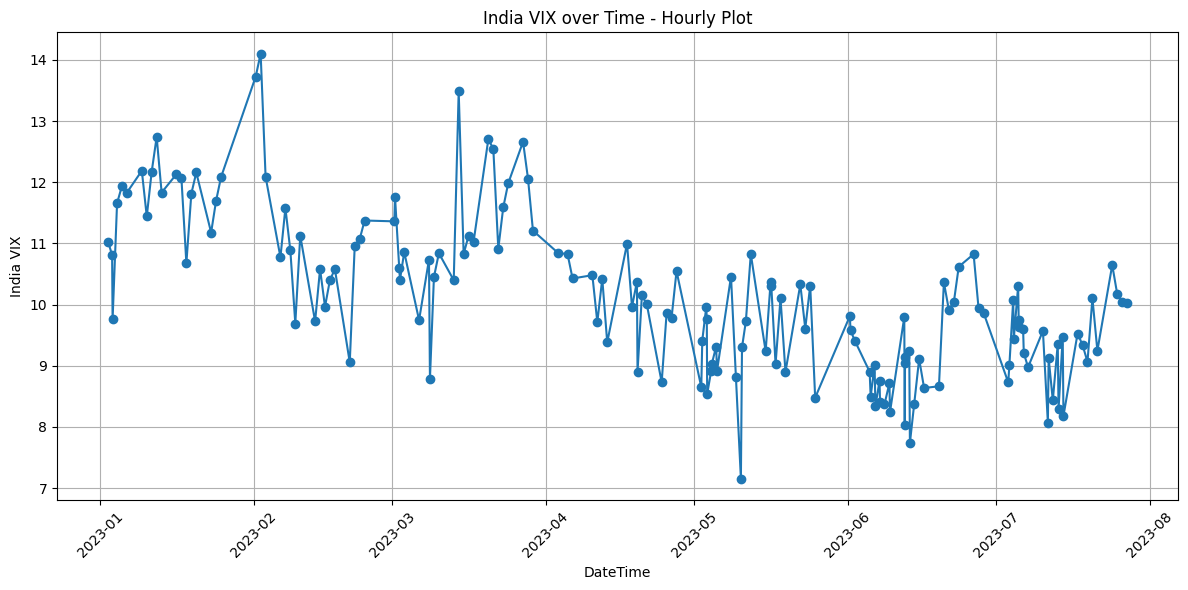

In [ ]:
# List of file paths
file_paths = ['2023-01.csv','2023-02.csv', '2023-03.csv', '2023-04.csv', '2023-05.csv','2023-06.csv', '2023-07.csv']
file_paths = [input_path + val for val in file_paths]

# Read each CSV file into a DataFrame and append to a list
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames in the list along rows
combined_df = pd.concat(dfs, ignore_index=True)

# Assuming combined_df is your DataFrame
# Convert 'date' and 'time' columns to datetime format
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['time'] = pd.to_timedelta(combined_df['time'])

# Create a new column for combined datetime
combined_df['datetime'] = combined_df['date'] + combined_df['time']

# Sort the DataFrame by 'datetime'
combined_df = combined_df.sort_values('datetime')

# Calculate the time difference between consecutive rows
combined_df['time_diff'] = combined_df['datetime'].diff()

# Filter the DataFrame to include only rows where the time difference is at least 1 hour
filtered_df = combined_df[combined_df['time_diff'] >= pd.Timedelta(hours=1)]

# Plot India VIX values
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['datetime'], filtered_df['India_VIX'], marker='o', linestyle='-')
plt.title('India VIX over Time - Hourly Plot')
plt.xlabel('DateTime')
plt.ylabel('India VIX')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()